In [4]:
from prevalence import plot_prevalence

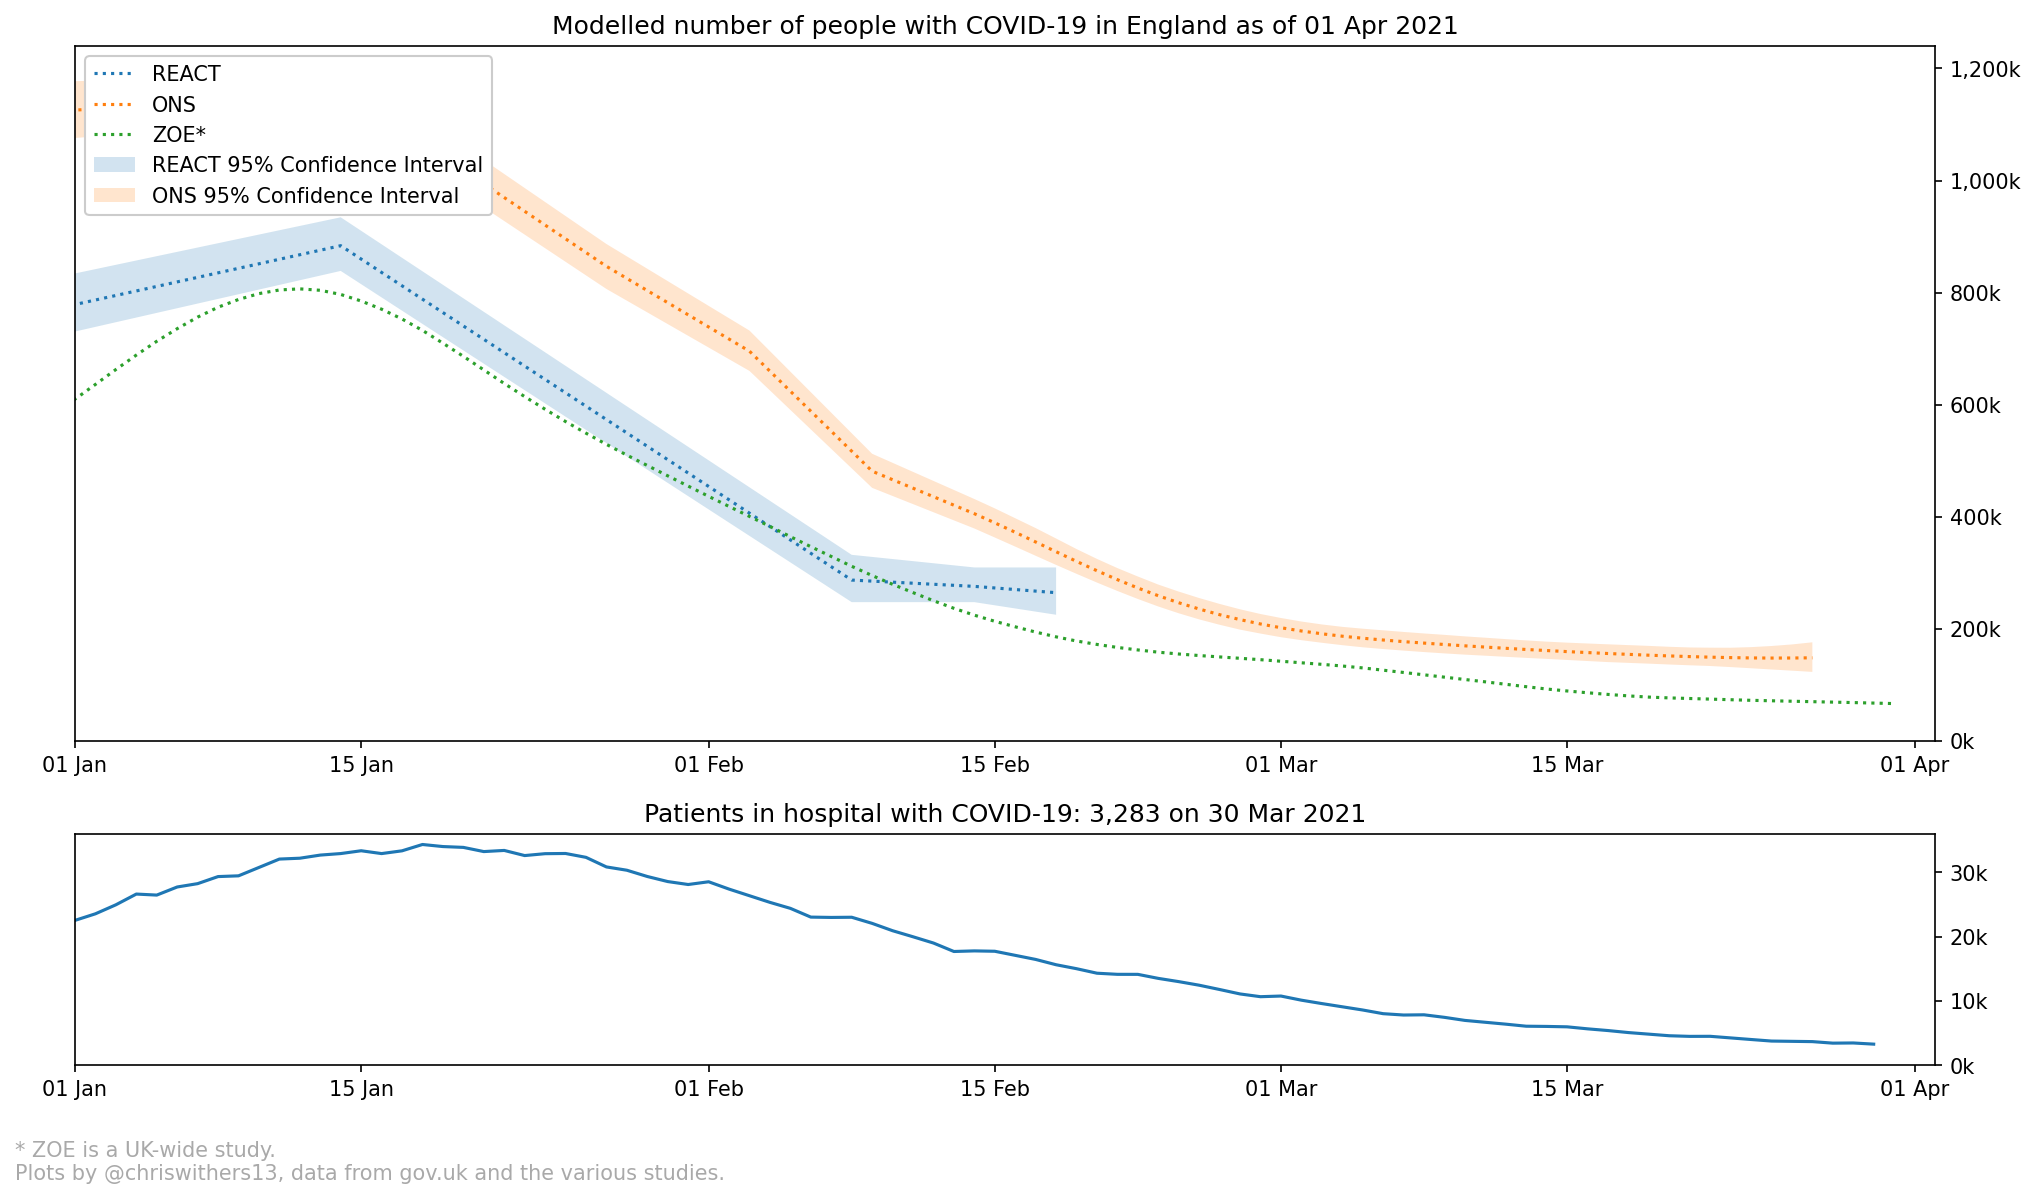

In [5]:
plot_prevalence(earliest='2021-01-01')

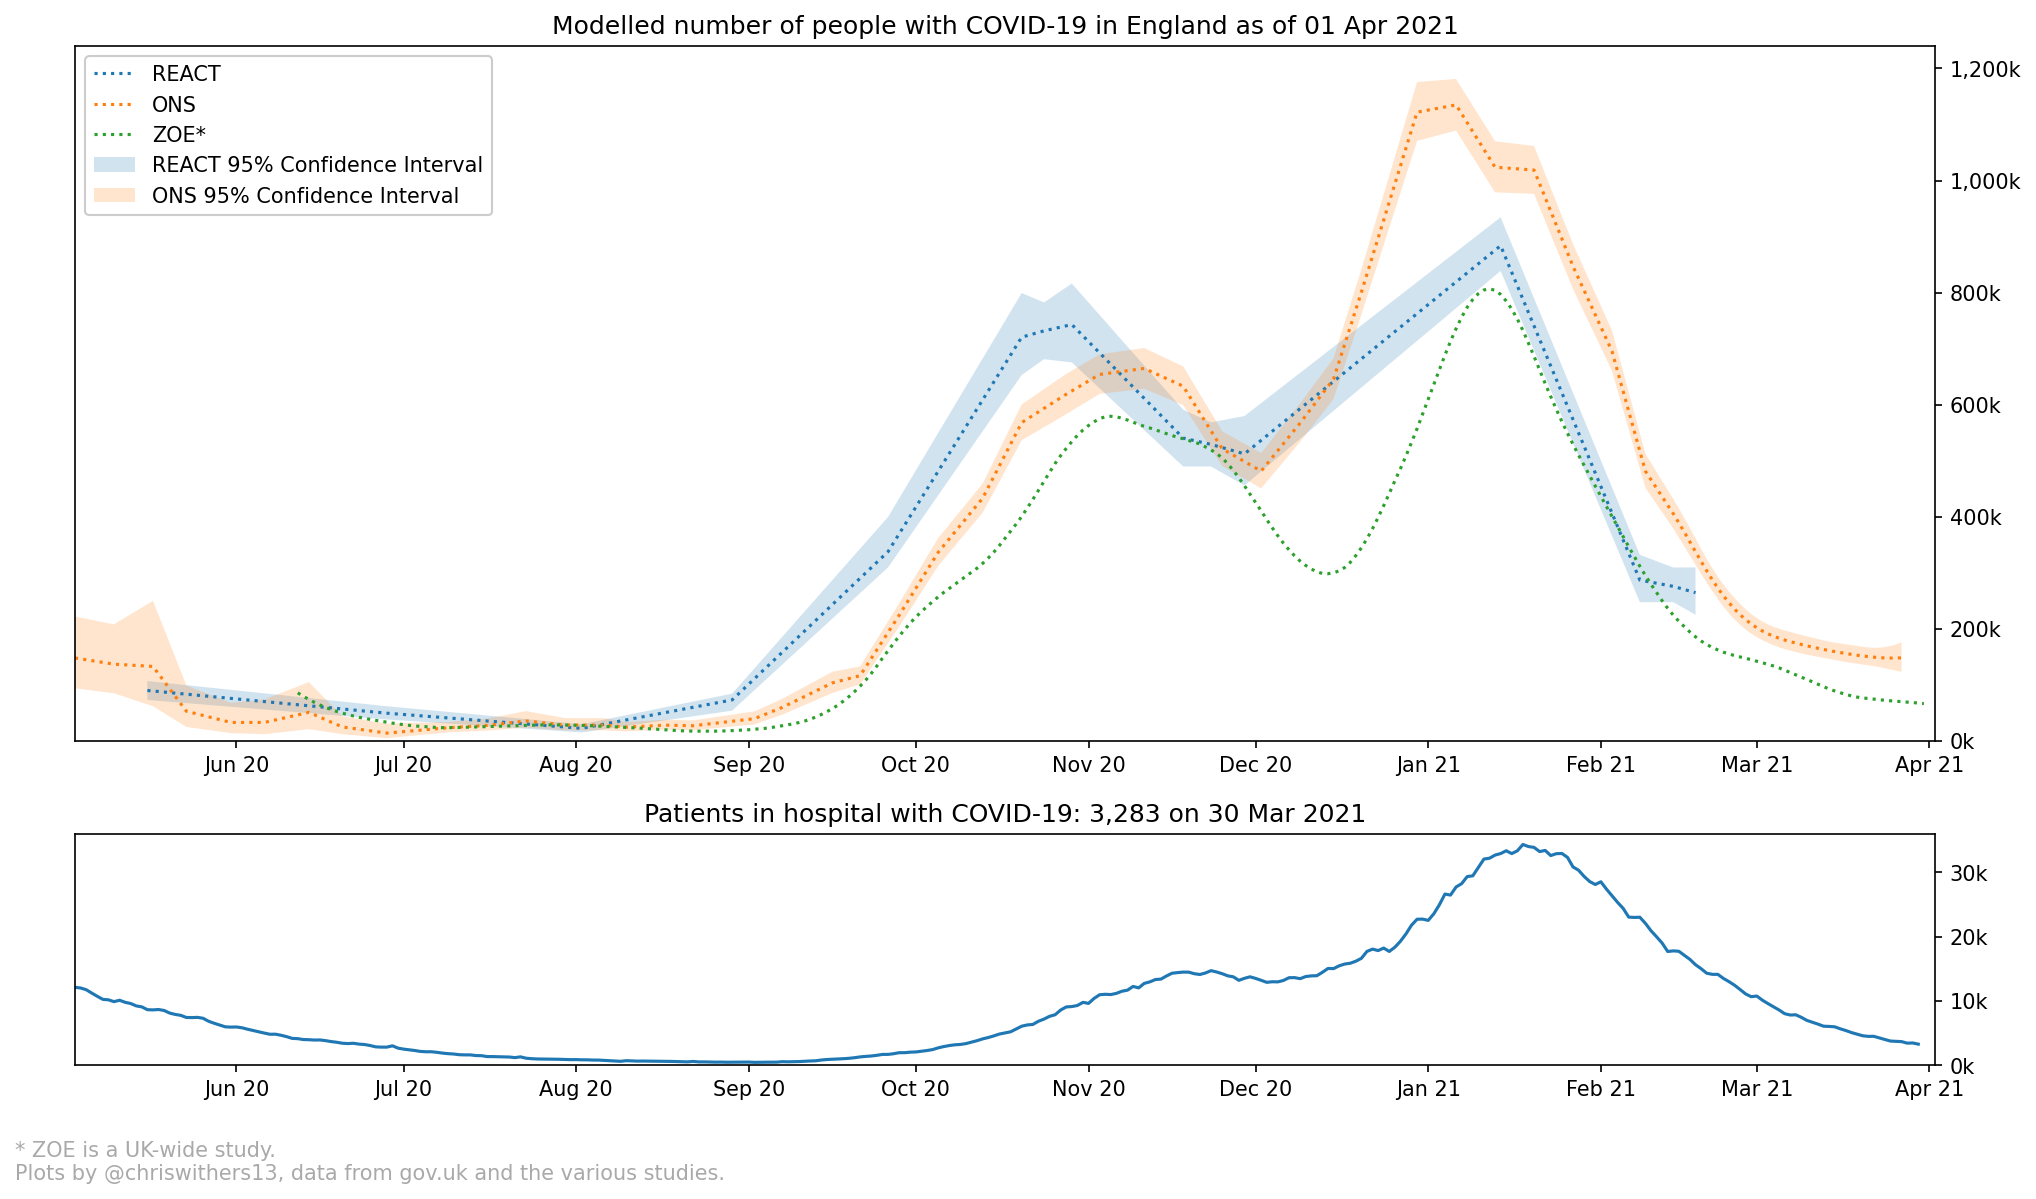

In [6]:
plot_prevalence()